### SNN WP

In [1]:
import snntorch as snn
import snntorch.functional as SF

from snntorch import spikeplot as splt

from snntorch import spikegen

import torch

import torch.nn as nn 
import matplotlib.pyplot as plt
import weight_perturbation as wp

In [2]:
# define a network


class SNN_WP(nn.Module):
    """
    SNN for weight perturbation. Consists of two fully connected layers of LIFs.
    """
    def __init__(self, beta, num_inputs, num_hidden, num_outputs, loss):
        """
        Initialize the network

        Parameters
        ----------
        beta : float
            The memory leakage of the LIF
        num_inputs : int
            The size of the input layer
        num_hidden : int
            The size of the output layer
        num_outputs : int
            The size of the output
        loss : Loss
            The loss used during training
        """
        super(SNN_WP, self).__init__()

        spike_grad = snn.surrogate.fast_sigmoid(slope=25) #needed for BP
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.loss = loss

    def clean_forward(self, x):
        """Wrapper function of forward for readability purposes"""
        return self.forward(x)

    def noisy_forward(self, x, noise):
        """Perturbs the weights and runs a forward pass

        Parameters
        ----------
        x : Array
            Input data as spike trains
        noise : dict
            Noise for each network parameter

        Returns
        -------
        spk : Array
            Output spike train
        """
        original_state = self.state_dict()
        params = self.named_parameters()
        trainable_params = {name: p.data for name, p in params if p.requires_grad}
        perturbed_params = wp.dictionary_add(trainable_params, noise)
        self.load_state_dict(perturbed_params, strict=False) 
        out = self.forward(x)

        # reset the parameters back to the unperturbed parameters
        self.load_state_dict(original_state)

        return out

    def forward(self, x):
        """Perturbs the weights and runs a forward pass

        Parameters
        ----------
        x : Array
            Input data as spike trains

        Returns
        -------
        spk : Array
            Output spike train
        """
        self.mem1 = self.lif1.init_leaky()
        self.mem2 = self.lif2.init_leaky()
        self.output_potential = torch.zeros(x.shape)
        for step in range(x.shape[1]):
            cur1 = self.fc1(x[:, step])  # post-synaptic current <-- spk_in x weight
            spk1, self.mem1 = self.lif1(cur1, self.mem1)  # mem[t+1] <--post-syn current + decayed membrane
            cur2 = self.fc2(spk1)
            spk2, self.mem2 = self.lif2(cur2, self.mem2)

            self.output_potential[:, step] = self.mem2
        return self.output_potential

    def forward_pass(self, x, y, noise=None):
        """Perturbs the weights and runs a forward pass

        Parameters
        ----------
        x : Array
            Input data as spike trains
        y : Array
            True labels
        noise : dict, optional
            Noise for each network parameter

        Returns
        -------
        loss : long
            The loss of the pass
        """
        if noise is None:
            y_pred = self.clean_forward(x)
            return self.loss(y_pred, y)
        else:
            y_pred = self.noisy_forward(x, noise)
            return self.loss(y_pred, y)

In [3]:
class PeriodicRegressionDataset(torch.utils.data.Dataset):
    """Simple regression dataset."""

    def __init__(self, num_samples, timesteps, dim_in):
        """Linear relation between input and output"""
        self.num_samples = num_samples  # number of generated samples
        feature_lst = []  # store each generated sample in a list

        phases = torch.rand(dim_in)
        amplitudes = torch.rand(dim_in)
        periods = torch.rand(dim_in)
        for idx in range(num_samples):

            for i in range(dim_in):
                end = float(torch.rand(1)*torch.pi*10)  # random final point
                lin_vec = torch.linspace(
                    start=0.0, end=end, steps=timesteps
                )  # generate periodic function from 0 to end
                feature = lin_vec.view(timesteps, 1)
                feature_lst.append(feature)  # add sample to list
        self.features = torch.stack(feature_lst, dim=1).view(
            timesteps, num_samples, dim_in
        )  # convert list to tensor

        self.labels = torch.sum(torch.sin(periods*(self.features+phases))*amplitudes, dim=-1).unsqueeze(-1)
        
        # scale between 0 and 1
        self.labels = self.labels - torch.min(self.labels)
        self.labels = self.labels / torch.max(self.labels)

    def __len__(self):
        """Number of samples."""
        return self.num_samples

    def __getitem__(self, idx):
        return self.features[:, idx, :], self.labels[:, idx, :]

In [9]:
# layer parameters
num_steps = 15
num_inputs = 1
num_hidden = 30
num_outputs = 1
beta = 0.99
loss = torch.nn.MSELoss()
SNN = SNN_WP(beta, num_inputs, num_hidden, num_outputs, loss)


# training parameters
loss_hist_wp = []
test_acc_hist_wp = []
loss_hist_bp = []
test_acc_hist_bp = []
epochs = 10
method = "cfd"
sigma = 1e-3
lr = 1e-6
device = "cpu"

In [5]:
dataset = PeriodicRegressionDataset(10, num_steps, num_inputs)

train_set, test_set = torch.utils.data.random_split(dataset, [9, 1])


train_loader = torch.utils.data.DataLoader(
    dataset=train_set, batch_size=1, drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set, batch_size=1, drop_last=True
)

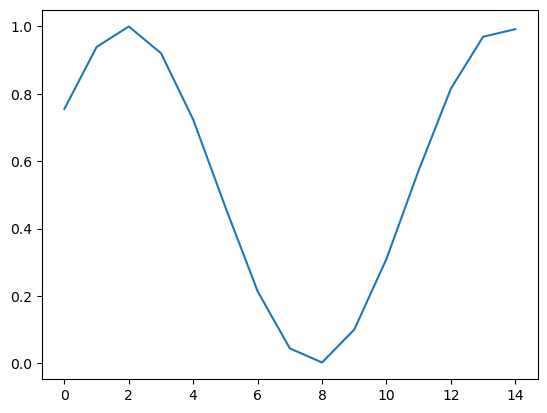

In [6]:
plt.plot(dataset[1][1])

In [7]:
def batch_accuracy(test_loader, net):
    with torch.no_grad():
        total = 0
        mse = 0
        net.eval()

        test_loader = iter(test_loader)
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            mem_rec = net(data)
            mse += torch.mean(torch.square(mem_rec - targets))
            total += mem_rec.size(1)

    return mse / total

In [10]:
# Training loop for WP
import math

sampler = torch.distributions.Normal(0, sigma)
# make a sampler

with torch.no_grad():
    for e in range(epochs):
        # get input and targets from task
        loss_epoch = []
        for data, targets in iter(train_loader):

            data = data.to(device)
            targets = targets.to(device)

            params = SNN.named_parameters()
            trainable_params = {name: p.data for name, p in params if p.requires_grad}

            loss = SNN.forward_pass(data, targets)
            loss_hist_wp.append(loss.item())

            wp_grad = wp.compute_snn_gradient(
                SNN.forward_pass, data, targets, trainable_params, sampler, method
            )  # do forward passes and compute gradient

            new_weights = wp.update_weights(wp_grad, trainable_params, sigma, lr)

            SNN.load_state_dict(new_weights, strict=False)  # update the weights. Huzzah

            loss_epoch.append(loss.item())

        loss_hist_wp.append(torch.mean(torch.tensor(loss_epoch)))

        with torch.no_grad():
            # Test set forward pass
            test_mse = batch_accuracy(test_loader, SNN)
            print(f"Epoch {e}, Test MSE: {test_mse:.2f}\n")
            test_acc_hist_wp.append(test_mse.item())

Epoch 0, Test MSE: 0.02

Epoch 1, Test MSE: 0.02

Epoch 2, Test MSE: 0.02

Epoch 3, Test MSE: 0.02

Epoch 4, Test MSE: 0.02

Epoch 5, Test MSE: 0.02

Epoch 6, Test MSE: 0.02

Epoch 7, Test MSE: 0.02

Epoch 8, Test MSE: 0.02

Epoch 9, Test MSE: 0.02



In [ ]:
with torch.no_grad():
    total = 0
    mse = 0
    net.eval()

    test_loader = iter(test_loader)
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)
        mem_rec = net(data)
        mse += torch.mean(torch.square(mem_rec - targets))
        total += mem_rec.size(1)

In [9]:
# Training loop for BP

optimizer = torch.optim.SGD(params=SNN.parameters(), lr=lr)


for e in range(epochs):

    loss_epoch = []

    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        SNN.train()

        y_pred = SNN(data)

        # initialize the loss & sum over time
        loss_val = SNN.loss(y_pred, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_epoch.append(loss_val.item())

    loss_hist_bp.append(torch.mean(torch.tensor(loss_epoch)))

    with torch.no_grad():
        # Test set forward pass
        test_mse = batch_accuracy(test_loader, SNN)
        print(f"Epoch {e}, Test MSE: {test_mse:.2f}\n")
        test_acc_hist_wp.append(test_mse.item())

Epoch 0, Test MSE: 0.01

Epoch 1, Test MSE: 0.01

Epoch 2, Test MSE: 0.01

Epoch 3, Test MSE: 0.01

Epoch 4, Test MSE: 0.01

Epoch 5, Test MSE: 0.01

Epoch 6, Test MSE: 0.01

Epoch 7, Test MSE: 0.01

Epoch 8, Test MSE: 0.01

Epoch 9, Test MSE: 0.01

